# Launch DPS for 3.1.2_dps.py
multi-spectral composites  

##### Notes on DPS processing with this algorithm  
To get a good greenest pixel growing season composite you probably want to:
1. build epochal seasonal composites across 3 seasons (havent looked closely at just 2 seasons yet)
2. specify a cloud cover max of 50%   
    - high (eg 75%) can result in long run times due to 175+ scenes for high lat tiles over 3 seasons. The result - no data void artifacts, but less smooth pixel results.   
    - Compare c2015 (2014-2016 summers; done mostly with 75% CC max thresh) with c2020 (2019-2021 summers; done mostly with 50% CC max thresh)
3. be ready to have your batch of 5000+ tiles NOT process all at once. In fact, processing will be a highly iterative endeavor because EarthData might not like so many requests coming from one source (not sure of this).  
    - MAAP devs looked into this in Fall 2022 and wrote some code with function decorators but this doesnt seem to have solved the problem.
    - MAAP devs can sometimes re-submit the 500 type errors that result - auto-resubmits may solve the problem.
    


### Completed HLS H30 Composites

In [1]:
# hls_2020_mscomp_mosaic_json_fn = '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/HLS/HLS_H30_2020/HLS_stack_2023_v1/HLS_tindex_master_mosaic.json'
# hls_2022_mscomp_mosaic_json_fn = '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/HLS/HLS_H30_2022/HLS_stack_2023_v1/HLS_tindex_master_mosaic.json'

In [577]:
from maap.maap import MAAP
maap = MAAP(maap_host='api.maap-project.org')
maap._MAAP_HOST

'api.maap-project.org'

In [578]:
# For some reason this is needed to get s3fs to work in ExtractUtils
# this upgrades to 0.3.4 even though we already specify this version in requirements_main...
#!pip install s3fs --upgrade

In [579]:
import s3fs

In [580]:
#!pip install -U -r /projects/requirements_notebooks.txt

In [581]:
from os import path
import os, glob
import datetime
import time

import geopandas as gpd
import pandas as pd
# !pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt
# !pip install xmltodict

import xmltodict
import sys
sys.path.append('/projects/Developer/icesat2_boreal/lib')
sys.path.append('/projects/code/icesat2_boreal/lib')
import ExtractUtils
import matplotlib
matplotlib.rcParams['figure.figsize'] = [30, 20]
import maplib_folium
from folium import *

import json

In [582]:
!python --version

Python 3.10.13


In [583]:
import s3fs
s3fs.__version__

'2023.12.2'

In [584]:
import rio_tiler
rio_tiler.__version__

'6.2.8'

In [585]:
import rio_cogeo
rio_cogeo.__version__

'5.1.1'

In [586]:
import morecantile
morecantile.__version__

'5.1.0'

In [587]:
import rasterio
rasterio.__version__

'1.3.7'

## Steps to commit, build DPS registration yaml, register DPS algorithm from yaml
### Commit with Tag for running
1) Tag the version of the repo that works to run your alg. Use a *tag* of `HLS_stack_2023_v1` or whatever is appropriate (eg, for AGB runs maybe do `boreal_agb_2023_v1` for consistency?)
  - to maintain sanity, use this GitHub *tag* also as the `algorithm_version` that you need to supply to your algorithm config yaml  
2) think now about how you want your output organized:  
  - remember, the output will be like: `dps_output/<algorithm name>/<algorithm_version>/<IDENTIFIER>`  
  - note: identifier for biomass runs should be `AGB_2020` , for height `HT_2020`  
  - if different types of `AGB_2020` runs (eg like is you are testing different sets of parameters associated with model dev/application you can keep the results separate from one run to the next, delivering the output into different subdirs, by modifying this IDENTIFIER like this: `AGB_2020/run_param_set01`
              
    
  
3) follow git instructions (every time!!):  
 - git add changes  
 - git commit -m 'message'  
 - git tag -f `HLS_stack_2023_v1`    
 - git push  
 - git push origin -f `HLS_stack_2023_v1`  
        # --push to gitlab no longer needed --   
        # git push dps    
        # git push dps -f `HLS_stack_2023_v1`    

3) if it looks weird check git log to make sure tag is at same place as origin and dps

### Build DPS Registration yaml  
- use MAAP Register Algorithm tool  
- refer to `code/icesat2_boreal/dps/registered/do_HLS_stack_3-1-2.yml` for existing template  
- update reg yaml repository url to the github url (gitlab no longer needed) 
- update `code/icesat2_boreal/dps/above_env.yml` and `code/icesat2_boreal/dps/build_command_main.sh` to include all pinned versions of packages - to ensure stability of env for this alg  

### Use MAAP Registration call in notebook chunk to register DPS algorithm
 - We need to register a DPS algorithm called 'do_HLS_stack_3-1-2' before proceeding to the chunks below...

In [67]:
maap.register_algorithm_from_yaml_file("/projects/code/icesat2_boreal/dps/registered/do_HLS_stack_3-1-2.yml").text

'{"code": 200, "message": {"id": "7684fb935b03c13ce10ef453eb665a556b0fe38e", "short_id": "7684fb93", "created_at": "2024-09-13T18:21:05.000+00:00", "parent_ids": ["01d9c112319c4fb8d687c0077804c9ee6b957173"], "title": "Registering algorithm: do_HLS_stack_3-1-2", "message": "Registering algorithm: do_HLS_stack_3-1-2", "author_name": "root", "author_email": "root@845666954fdb", "authored_date": "2024-09-13T18:21:05.000+00:00", "committer_name": "root", "committer_email": "root@845666954fdb", "committed_date": "2024-09-13T18:21:05.000+00:00", "trailers": {}, "web_url": "https://repo.maap-project.org/root/register-job-hysds-v4/-/commit/7684fb935b03c13ce10ef453eb665a556b0fe38e", "stats": {"additions": 3, "deletions": 3, "total": 6}, "status": "pending", "project_id": 3, "last_pipeline": {"id": 14550, "iid": 1465, "project_id": 3, "sha": "7684fb935b03c13ce10ef453eb665a556b0fe38e", "ref": "main", "status": "pending", "source": "push", "created_at": "2024-09-13T18:21:06.773Z", "updated_at": "20

In [ ]:
#!python /projects/register-algorithm /projects/Developer/icesat2_boreal/dps/alg_3-1-2/algorithm_config.yaml

# Show status of MS composites for boreal tiles: find tiles still NEEDED
    Colored tiles indicate those still needed - water tiles removed
    BLACK tiles are processed

# Build a DPS list

In [588]:
s3 = s3fs.S3FileSystem(anon=True)

In [589]:
#
# Use Topo tiles to find first set of tiles for DPS
#

# Orig topo tiles
tindex_master_fn = "s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv" #.replace('s3://maap-ops-workspace/shared/nathanmthomas', '/projects/my-public-bucket')
# New topo tiles
tindex_master_fn = 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/run_build_stack_topo/build_stack_v2023_2/CopernicusGLO30/Topo_tindex_master.csv'
tindex = pd.read_csv(tindex_master_fn, storage_options={'anon':True})

# Model-ready tiles
tindex_master_fn = 's3://maap-ops-workspace/shared/montesano/databank/boreal_tiles_v004_model_ready.gpkg'
tindex = gpd.read_file(tindex_master_fn)

INPUT_TILE_NUM_LIST = tindex['tile_num'].to_list()

print(f"Input list: {len(INPUT_TILE_NUM_LIST)}")

if False:
    m = boreal_tiles.explore(color='red')
    boreal_tiles[boreal_tiles.tile_num.isin(INPUT_TILE_NUM_LIST)].explore(m=m)

Input list: 4956


In [590]:
if DICT_RUN_NAME_TIME is None:
    DICT_RUN_NAME_TIME = dict()#.fromkeys([RUN_NAME])
print(DICT_RUN_NAME_TIME)

{'mc25_07-01_08-31_2017_2017': '202409160531'}


# Prepare a DPS of MS Composite tiles

__Launch dates of HLS relevant satellites:__   

Landsat-8: 2/11/2013  
Sentinel-2 6/23/2015  
Landsat-9 9/27/2021

Various MS composites will be built 

1. a circa 2020 composite (with 2019-2021 data)
2. a circa 2015 composite (with 2014-2016 data) 

__Anticipate Errors:__  
__ERROR__ _No module found: MAAP module_  
`failed\nTraceback (most recent call last):\n  File "/app/icesat2_boreal/dps/alg_3-1-2/../../lib/3.1.2_dps.py", line 17, in <module>\n    from fetch_HLS import get_HLS_data\n  File "/app/icesat2_boreal/lib/fetch_HLS.py", line 14, in <module>\n    from maap.maap import MAAP\nModuleNotFoundError: No module named \'maap\'\n+ cp _stderr.txt _alt_traceback.txt'}}}`

We see this error after Laura has made commits to run some version of our `run_boreal_biomass` class of algorithms.

We use a `tag` so the container should not be changing. 

__FIX:__  re-register the algorithm

__ERROR__ _Bad Gateway_  
`502 Bad Gateway</title></head>\n<body>\n<center><h1>502 Bad Gateway`

For next alg update (per conversation with Sujen Feb 2023):  
1. make changes to alg  
2. test locally  
3. update `dps/alg_3-1-2/build_algorithm.sh` < -- use this instead of the repos build_command.sh : so, in `algorithm_config.yaml` use this file's path
4. create a new tag associated with latest commit (`HLS...v3`), commit, push (see instructions at top here)  
5. re-register the `algorithm_config.yaml`


#### Completed HLS composites

Lists are archived here: `/projects/shared-buckets/nathanmthomas/DPS_tile_lists/HLS`
 - 2022: `/HLS_H30_2022/HLS_stack_2023_v1`  
 - 2020: `/HLS_H30_2020/HLS_stack_2023_v1`  
 - c2015: `/c2015/HLS_stack_2022_v2`   <-- do this over with alg tag `HLS_stack_2023_v1` using ONLY 2015 (now that S30 data available)  
 - 2015:  up next  

In [646]:
YEAR_START = '2020' #2017 2019 2020 2023
YEAR_STOP =  '2020'
HLS_PRODUCT = 'H30'

In [647]:
import numpy as np
MEAN_YEAR = int(np.mean([int(YEAR_STOP) , int(YEAR_START)]))
MEAN_YEAR
if (int(YEAR_STOP)-int(YEAR_START)) > 0: 
    YEAR_STRING = f'c{MEAN_YEAR}'
else: 
    YEAR_STRING = MEAN_YEAR
YEAR_STRING

2020

In [648]:
SEASON_START = '07-01'
SEASON_STOP = '08-31' 

MAX_CLOUDS = 50     #90 #50 #10 25

MS_COMP_NAME = f'HLS_{HLS_PRODUCT}_{YEAR_STRING}'    
RUN_NAME = f'mc{MAX_CLOUDS}_{SEASON_START}_{SEASON_STOP}_{YEAR_START}_{YEAR_STOP}'
IDENTIFIER = f'{MS_COMP_NAME}/{RUN_NAME}'
IDENTIFIER

'HLS_H30_2020/mc50_07-01_08-31_2020_2020'

### Re-run this batch with same tile-specific composite params as spring2022


In [649]:
DO_MATCH_PREVIOUS_PARAMS = False
DO_EXPERIMENT = False

In [650]:
TEST_DPS  = False

In [651]:
DO_REDO = True
MISSING_TILES = []
REDO_TILES_LIST = [3610] + [3176, 2588, 3266, 3083, 3084, 41056, 41053, 41054, 41055, 41056, 3263, 3264, 3173, 3174]
REDO_TILES_LIST = [3081, 41246, 41247, 41248, 3172, 3173, 3174, 3266, 3083, 3084, 3176]
MINI_DATELINE_TILES = [400400,391600,382300,372800,363400,354000,4199500,4180700,4161900]
LARGE_DATELINE_TILES = [3540,3634,3728,3823,3916,4004,41995,41807,41619]
REDO_TILES_LIST = MINI_DATELINE_TILES + LARGE_DATELINE_TILES
#REDO_TILES_LIST = [45970] #27636
#REDO_TILES_LIST = list(MISSING_TILES) #[997]
# REDO_TILES_LIST = [37149]
# REDO_TILES_LIST = [24615, 24616, 24619, 24897, 24898, 24899, 24900, 24901, 24902, 24903, 25180, 25181, 25182, 25183, 25184, 25736, 25737, 25738, 25739, 25740, 25741, 25742, 25743, 26014, 26015, 26016, 26017, 26018, 26019, 26020, 26293, 26294, 26295, 27646, 27647, 27914, 27915, 27916, 27917, 27918, 27919, 27920, 27109, 27110, 27111, 728, 729, 730, 731, 732, 778, 683, 684, 685, 686, 1302, 1303, 1363, 3186, 3094, 3378, 3379, 3471, 3472, 987, 988, 937, 938, 703, 704, 658, 659, 1214, 1215, 1216, 35578, 1159, 1160, 1161, 35352, 35353, 36918, 36919, 36920, 36921, 36922, 36923, 36924, 36693, 36694, 36695, 36696, 36697, 36698, 36699, 37145, 37146, 37147, 37148, 37149, 37150, 37372, 37373, 37374]
# REDO_TILES_LIST = [987,988,937,938,539,499,23828,24951,24952,24670,24671,24672,24389,24390,24391,24108,24109,24110] + list(range(25460,25464+1))+[24620,25180,24899,25744,25745,26022,26023,26298]
# REDO_TILES_LIST = [498,538,988,41247,41248,3081,3082,3171,3172,3173,41054,41055,41056]

In [652]:
GET_MISSING_TILES = False

In [653]:
if TEST_DPS:
    print('Running DPS on a SUBSET list of input')
    DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST[110:]
else:
    if DO_MATCH_PREVIOUS_PARAMS:
        print('Running DPS on the subset list with matched params')
        OUTPUT_FN = '/projects/my-public-bucket/DPS_tile_lists/HLS/spring2022/HLS_input_params.csv'
        df = pd.read_csv(OUTPUT_FN)
        DPS_INPUT_TILE_NUM_LIST = df[(df.max_cloud == MAX_CLOUDS) & 
                       (df.start_month_day ==SEASON_START) & 
                       (df.end_month_day == SEASON_STOP)
                      ].in_tile_num.to_list()
    elif DO_EXPERIMENT:
        print('Running DPS on the FULL list of EXPERIMENT input')
        DPS_INPUT_TILE_NUM_LIST = MISC_TILES + INPUT_EXPERIMENT_TILE_NUM_LIST
    else:
        if DO_REDO:
            print('Running DPS on the a REDO tile list')
            DPS_INPUT_TILE_NUM_LIST = REDO_TILES_LIST
        else:
            if GET_MISSING_TILES:
                # Get text files (most recent) for HLS H30 year of interest
                fn = glob.glob(f'/projects/my-public-bucket/DPS_tile_lists/tmp/*HLS_H30_{YEAR_START}_*.txt')[-1]

                #Now read the file back into a Python list object
                with open(fn, 'r') as f:
                    DPS_INPUT_TILE_NUM_LIST = json.loads(f.read())
                print('Running DPS on the list of missing tiles retrieved from the HLS assessment notebook:')
                print(f"List length from text file: {len(DPS_INPUT_TILE_NUM_LIST)}")
            else:
                print('Running DPS on the FULL list of input')
                DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST
    
print(f"List length: {len(DPS_INPUT_TILE_NUM_LIST)}")
print(f'\nDPS identifier: {IDENTIFIER}')

Running DPS on the a REDO tile list
List length: 18

DPS identifier: HLS_H30_2020/mc50_07-01_08-31_2020_2020


# Run a DPS of MS Composite tiles

In [654]:
# MAAP algorithm version name (same as the repo TAG)
ALG_VERSION = "HLS_stack_2023_v1" 
#ALG_VERSION = "HLS_stack_2022_v2"

In [655]:
ALGO_ID = "do_HLS_stack_3-1-2"
USER = 'montesano'
WORKER_TYPE = 'maap-dps-worker-32gb'

## DPS job submission in serial

In [656]:
# Dont process thousands at once - EarthData no like?
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

tindex = gpd.read_file( '/projects/shared-buckets/montesano/databank/boreal_tiles_v004_model_ready.gpkg')
tindex.head()
tindex['tile_group'] = pd.Categorical(tindex['tile_group'])
tindex['tile_group'].cat.categories

Index(['alaska extra', 'canada extra', 'conus extra', 'eurasia central',
       'eurasia east', 'eurasia north', 'eurasia west', 'europe north',
       'fennoscand south', 'north america centra', 'north america east',
       'north america west', 'uk'],
      dtype='object')

In [657]:
# Build group lists of remaining tiles, and chunk up
if False:
    for group in tindex['tile_group'].cat.categories:
        GROUP_DPS_INPUT_TILE_NUM_LIST = []
        TILE_NUM_LIST = tindex[tindex['tile_group'] == group].tile_num.to_list()
        for TILE_NUM in TILE_NUM_LIST:
            if TILE_NUM in DPS_INPUT_TILE_NUM_LIST:
                GROUP_DPS_INPUT_TILE_NUM_LIST.append(TILE_NUM)
        print(chunker(GROUP_DPS_INPUT_TILE_NUM_LIST,100))

In [658]:
BATCH_SIZE = 100
WAIT_MINS = 5
IDENTIFIER

'HLS_H30_2020/mc50_07-01_08-31_2020_2020'

In [659]:
DPS_INPUT_TILE_NUM_LIST = [363400] #, 354000, 3540, 3634] #2017
#DPS_INPUT_TILE_NUM_LIST = [41807, 41619] # 2023
#DPS_INPUT_TILE_NUM_LIST = [41995, 41807, 41619] # 2022
DPS_INPUT_TILE_NUM_LIST = LARGE_DATELINE_TILES
DPS_INPUT_TILE_NUM_LIST = [354000] #[3540, 3634, 354000, 363400] # 2020
DPS_INPUT_TILE_NUM_LIST

[354000]

In [660]:
%%time
submit_results_df_list = []
len_input_list = len(DPS_INPUT_TILE_NUM_LIST)
print(f"# of input tiles for DPS: {len_input_list}")

for i, INPUT_TILE_NUM in enumerate(DPS_INPUT_TILE_NUM_LIST):

    DPS_num = i+1
    IDENTIFIER = IDENTIFIER 
    ALGO_ID = "do_HLS_stack_3-1-2"
    USER = 'montesano'
    WORKER_TYPE = 'maap-dps-worker-32gb'
    
    in_param_dict = {
                         'in_tile_fn': 'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg',
                         'in_tile_num': INPUT_TILE_NUM,
                         'in_tile_layer': 'boreal_tiles_v004',
                         'sat_api': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD',
                        #'sat_api': 'https://landsatlook.usgs.gov/sat-api',
                         'tile_buffer_m': 0,
                         'start_year': YEAR_START,
                         'end_year': YEAR_STOP,
                         'start_month_day': SEASON_START,
                         'end_month_day': SEASON_STOP,
                         'max_cloud': MAX_CLOUDS,
                         'composite_type': 'HLS',
                         'shape': 3000,
                         'hls_product': 'H30'
        }
        
    submit_result = maap.submitJob(
                                    identifier=IDENTIFIER,
                                    algo_id=ALGO_ID,
                                    version=ALG_VERSION, # "HLS_stack_2023_v1"
                                    username=USER,
                                    queue=WORKER_TYPE,
                                    # Args that match yaml
                                    **in_param_dict
        )
    
    # Build a dataframe of submission details
    submit_result_df = pd.DataFrame( 
        {
                'dps_num':[DPS_num],
                'tile_num':[INPUT_TILE_NUM],
                'submit_time':[datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%s')],
                'dbs_job_hour': [datetime.datetime.now().hour],
                'algo_id': [ALGO_ID],
                'user': [USER],
                'worker_type': [WORKER_TYPE],
                'job_id': [submit_result.id],
                'submit_status': [submit_result.status],
            
        } 
    )
    
    # Append to a list of data frames of submission results
    submit_results_df_list.append(submit_result_df)
    
    if DPS_num in [1, 5, 10, 50, 100, 250, 500, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 7000, 9000, 11000, 13000, 15000, 17000, 19000, 21000, 24000, len_input_list]:
        print(f"DPS run #: {DPS_num}\t| tile num: {INPUT_TILE_NUM}\t| submit status: {submit_result.status}\t| job id: {submit_result.id}") 
    
    # Choose a BATCH_SIZE that plays nice with EarthData - don try to do too many simultaneous MS comp jobs...
    if DPS_num in list(range(BATCH_SIZE, len(DPS_INPUT_TILE_NUM_LIST), BATCH_SIZE)):
        print(f'...waiting {WAIT_MINS} minutes...')
        time.sleep(60 * WAIT_MINS) # sleep time in seconds
 
# Build a final submission results df and save
submit_results_df = pd.concat(submit_results_df_list)
submit_results_df['run_name'] = RUN_NAME
nowtime = pd.Timestamp.now().strftime('%Y%m%d%H%M')
print(f"Current time:\t{nowtime}")
submit_results_df.to_csv(f'/projects/my-public-bucket/dps_submission_results/DPS_{ALGO_ID}_{RUN_NAME}_submission_results_{len_input_list}_{nowtime}.csv')
submit_results_df.info()

# of input tiles for DPS: 1
DPS run #: 1	| tile num: 354000	| submit status: success	| job id: 8ca3f90e-1930-4da3-8e39-858068bbedad
Current time:	202409160907
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   dps_num        1 non-null      int64 
 1   tile_num       1 non-null      int64 
 2   submit_time    1 non-null      object
 3   dbs_job_hour   1 non-null      int64 
 4   algo_id        1 non-null      object
 5   user           1 non-null      object
 6   worker_type    1 non-null      object
 7   job_id         1 non-null      object
 8   submit_status  1 non-null      object
 9   run_name       1 non-null      object
dtypes: int64(3), object(7)
memory usage: 208.0+ bytes
CPU times: user 31.1 ms, sys: 0 ns, total: 31.1 ms
Wall time: 345 ms


After almost any DPS job, you have to assess what succeeded and failed. This involves:
1. building a table of job status based on job ids captured in the job_results_df from the DPS run chunk (this takes 40 mins for ~47k jobs) --> this tells you how many jobs failed
2. merging the job status table with the job results df --> this tells you which specific granules (or tile nums) failed
3. building another input list of granules for a follow-up DPS
## Assess DPS results
Build a table of job status based on job id - how many jobs failed?

In [631]:
import importlib
importlib.reload(ExtractUtils)

NASA MAAP


<module 'ExtractUtils' from '/projects/code/icesat2_boreal/lib/ExtractUtils.py'>

#### Update the dict of DPS runs to monitor success and fails

In [632]:
if False:
    DICT_RUN_NAME_TIME = dict()
    nowtime = '202409131721'
    RUN_NAME = 'mc25_07-01_08-31_2017_2017'

In [633]:
#nowtime = '202304221859'
#RUN_NAME = 'mc90_07-01_08-31_2022_2022-13'
DICT_RUN_NAME_TIME.update([(RUN_NAME, nowtime)])

In [634]:
for DICT_RUN_NAME, DPS_DATETIME in DICT_RUN_NAME_TIME.items():
    print(DICT_RUN_NAME, DPS_DATETIME)

mc25_07-01_08-31_2017_2017 202409160531
mc50_07-01_08-31_2024_2024 202409160817
mc50_07-01_08-31_2020_2020 202409160840


In [661]:
TMP_LIST = sorted(glob.glob(f'/projects/my-public-bucket/dps_submission_results/DPS_{ALGO_ID}*_submission_results_*.csv'), key=ExtractUtils.func, reverse=True)
LIST_SUBMISSIONS = TMP_LIST[0:3]
LIST_SUBMISSIONS

['/projects/my-public-bucket/dps_submission_results/DPS_do_HLS_stack_3-1-2_mc50_07-01_08-31_2020_2020_submission_results_1_202409160907.csv',
 '/projects/my-public-bucket/dps_submission_results/DPS_do_HLS_stack_3-1-2_mc50_07-01_08-31_2020_2020_submission_results_4_202409160840.csv',
 '/projects/my-public-bucket/dps_submission_results/DPS_do_HLS_stack_3-1-2_mc50_07-01_08-31_2024_2024_submission_results_9_202409160817.csv']

In [664]:
%%time

running_list = []
fails_list = []
success_list = []
offline_list = []

for fn in LIST_SUBMISSIONS:
    
    if not 'job_status' in fn:

        DPS_alg_id = os.path.basename(fn.split('_submission_results_')[0].replace('DPS_',''))
        thentime = fn.split('_')[-1].replace('.csv','')
        print(f'DPS alg:\t\t{DPS_alg_id}')
        print(f'DPS run name:\t\t{DICT_RUN_NAME}')
        print(f'DPS launch time:\t{thentime}')

        # Build job status table
        df_jstatus = ExtractUtils.BUILD_TABLE_JOBSTATUS(pd.read_csv(fn))

        # Save job status table
        df_jstatus.to_csv(f'/projects/my-public-bucket/dps_submission_results/DPS_{RUN_NAME}_submission_results_job_status_{len(df_jstatus)}_{thentime}.csv')

        # Get current fails df and append to list
        df_jstatus['run_type'] = DICT_RUN_NAME

        running_list.append(df_jstatus[ (df_jstatus['status'] == 'Running') ] )
        fails_list.append(  df_jstatus[ (df_jstatus['status'] == 'Failed') ] )
        success_list.append(df_jstatus[ (df_jstatus['status'] == 'Succeeded') ] )
        offline_list.append(df_jstatus[ (df_jstatus['status'] == 'Offline') ] )    
        
    df_all_running = pd.concat(running_list)          
    df_all_fails   = pd.concat(fails_list)
    df_all_success = pd.concat(success_list)
    df_all_offline = pd.concat(offline_list)

    print(f"Count offline jobs:\t{len(df_all_offline)}\n")  

DPS alg:		do_HLS_stack_3-1-2_mc50_07-01_08-31_2020_2020
DPS run name:		mc50_07-01_08-31_2020_2020
DPS launch time:	202409160907
multiprocessing...
Count total jobs:	1
Count pending jobs:	0
Count running jobs:	0
Count succeeded jobs:	1
Count failed jobs:	0
% of failed jobs:	Nothing has failed...yet

Count offline jobs:	0

DPS alg:		do_HLS_stack_3-1-2_mc50_07-01_08-31_2020_2020
DPS run name:		mc50_07-01_08-31_2020_2020
DPS launch time:	202409160840
multiprocessing...
Count total jobs:	4
Count pending jobs:	0
Count running jobs:	0
Count succeeded jobs:	3
Count failed jobs:	1
% of failed jobs:	25.0

Count offline jobs:	0

DPS alg:		do_HLS_stack_3-1-2_mc50_07-01_08-31_2024_2024
DPS run name:		mc50_07-01_08-31_2020_2020
DPS launch time:	202409160817
multiprocessing...
Count total jobs:	9
Count pending jobs:	0
Count running jobs:	0
Count succeeded jobs:	9
Count failed jobs:	0
% of failed jobs:	Nothing has failed...yet

Count offline jobs:	0

CPU times: user 80.9 ms, sys: 652 ms, total: 733 ms

### Get a list of the FAILS to run through DPS again
#### Build a dict of the list of fails for each run name

In [642]:
TILE_FAILS_DICT = dict()
for name, group in df_all_fails.groupby('run_name'):
    TILE_FAILS_DICT.update([(name, group.tile_num.to_list())])

In [643]:
df_all_fails

Unnamed: 0  dps_num  tile_num                  submit_time  dbs_job_hour  \
2           0        3     35400  2024-09-16-08-40-1726501243             8   

              algo_id       user           worker_type  \
2  do_HLS_stack_3-1-2  montesano  maap-dps-worker-32gb   

                                 job_id submit_status  \
2  81867a49-4dc0-4614-b045-6dac3e298ceb       success   

                     run_name  status                    run_type  
2  mc50_07-01_08-31_2020_2020  Failed  mc50_07-01_08-31_2020_2020

In [514]:
# Manually specify a specific run name
#DICT_RUN_NAME = 'mc10_07-01_08-31_2018_2018'

In [359]:
DPS_INPUT_TILE_NUM_LIST = TILE_FAILS_DICT[DICT_RUN_NAME]

KeyError: 'mc10_07-01_08-31_2016_2016'

In [548]:
GET_MISSING_TILES = False
len(TILE_FAILS_DICT[DICT_RUN_NAME])

1

In [626]:
num_fails = len(DPS_INPUT_TILE_NUM_LIST)
##RUN_NAME = DICT_RUN_NAME + f"_{num_fails}fails"
print(f"Re-try {num_fails}: {DICT_RUN_NAME}")

Re-try 2: mc75_07-01_08-31_2021_2021


In [519]:
DPS_INPUT_TILE_NUM_LIST = [3548, 3798, 4161, 25741, 27096, 27378, 27380, 31260, 31759, 37149]
len(DPS_INPUT_TILE_NUM_LIST)
DPS_INPUT_TILE_NUM_LIST

[3548, 3798, 4161, 25741, 27096, 27378, 27380, 31260, 31759, 37149]

### Look at the error log an an index location of a failed job

In [553]:
job_id = '4abcc02e-2005-4cba-bc55-9c406d1a8cd6'

In [ ]:
for job_id in df_all_fails.job_id.to_list():
    print(f"Job ID: {job_id}")
    print(f"\t{maap.getJobResult(job_id)[-1]}") #.split('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')[-1]}")

In [ ]:
INDEX_LOC = 0
JOB_ID_CHECK = df_all_fails.iloc[INDEX_LOC].job_id

result_list = maap.getJobResult(JOB_ID_CHECK)

# api.ops

if True:
    traceback_errors = result_list[-1].split('\nTraceback')
    traceback_errors[-1]
    len(traceback_errors)#[-3:]
    [print(f'\n{e}') for e in traceback_errors]
else:
    #print(traceback_errors[-1])
    #print(len(result_list[-1].split('api.')))
    print(result_list)

# Local test: does an HLS composite run locally

In [428]:
#!python /projects/code/icesat2_boreal/lib/3.1.2_dps.py --in_tile_fn /projects/shared-buckets/montesano/databank/boreal_tiles_v004.gpkg --in_tile_num 37149 --in_tile_layer boreal_tiles_v004 --sat_api https://cmr.earthdata.nasa.gov/stac/LPCLOUD --tile_buffer_m 0 --start_year 2021 --end_year 2021 --start_month_day 07-01 --end_month_day 08-31 --max_cloud 50 --composite_type HLS --shape 3000 --hls_product H30 -o /projects/local_output --search_only

In [31]:
DPS_INPUT_TILE_NUM_LIST = [37149, 2422]

In [ ]:
INDEX_FN =  'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/boreal_tiles_v004.gpkg'
INDEX_LYR = 'boreal_tiles_v004'
SAT_API = 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD'
OUTDIR = '/projects/my-private-bucket/tmp'
YEAR = 2014
MS_DATA_TYPE = 'HLS'

args = f"-i {INDEX_FN} \
-lyr {INDEX_LYR} \
-a {SAT_API} \
--tile_buffer_m 0 \
--in_tile_num {2422} \
-o {OUTDIR} \
-sy {YEAR} -ey {YEAR} -smd {SEASON_START} -emd {SEASON_STOP} -mc {0} \
--composite_type {MS_DATA_TYPE} \
--hls_product H30 \
--rangelims_red 0 1 \
--thresh_min_ndvi -1 \
--search_only"

cmd = f'python /projects/code/icesat2_boreal/lib/3.1.2_dps.py {args}'
!echo $cmd
!eval $cmd
#!echo
#!eval $cmd

# Build a tindex, mosaic json, & MS params df

In [77]:
#!pip install cogeo_mosaic

In [665]:
#DPS_IDENTIFIER = f'{ALG_VERSION}/{IDENTIFIER}'
#for YEAR in [2016,2017,2018,2019,2020,2021,2022,2023]:
#for YEAR in [2017,2019,2020,2023]:

for YEAR in [2024, 2020]: #,2023, 2022, 2021, 2020, 2019, 2018, 2017]:

    print(YEAR)
    MS_COMP_NAME = f'HLS_H30_{YEAR}'
    DPS_tile_list_IDENTIFIER = f'{ALG_VERSION}/{MS_COMP_NAME}'
    
    DPS_MONTH_LIST = '01 03 04 09 10 11 12'
    DPS_YEAR_LIST = '2023 2024'
    TYPE = 'HLS'

    DPS_DAY_MIN = 1
    OUTDIR = f'/projects/my-public-bucket/DPS_tile_lists/{TYPE}/{DPS_tile_list_IDENTIFIER}'
    !mkdir -p $OUTDIR

    # Build tindex
    args = f"--RETURN_DUPS \
    --user {USER} \
    --dps_identifier {DPS_tile_list_IDENTIFIER} \
    -alg_name {ALGO_ID} \
    -t {TYPE} \
    -y_list {DPS_YEAR_LIST} \
    --dps_month_list {DPS_MONTH_LIST} \
    -d_min {DPS_DAY_MIN} \
    --outdir {OUTDIR}"

    !time /projects/env/above/bin/python /projects/code/icesat2_boreal/lib/build_tindex_master.py $args 

2024
NASA MAAP
INFO: Pandarallel will run on 25 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
NASA MAAP

Building a list of tiles:
DPS ID:		HLS_stack_2023_v1/HLS_H30_2024
Type:		HLS
Year:		['2023', '2024']
Month:		['01', '03', '04', '09', '10', '11', '12']
Days:		1-31

Output dir:  /projects/my-public-bucket/DPS_tile_lists/HLS/HLS_stack_2023_v1/HLS_H30_2024
# of duplicate tiles: 9
Final # of tiles: 18
Writing duplicates csv: /projects/my-public-bucket/DPS_tile_lists/HLS/HLS_stack_2023_v1/HLS_H30_2024/HLS_tindex_master_duplicates.csv
Writing tindex master csv: /projects/my-public-bucket/DPS_tile_lists/HLS/HLS_stack_2023_v1/HLS_H30_2024/HLS_tindex_master.csv
Building geodataframe of matches, tindex master json, and mosaic json...
Tile index matches geodataframe for json: (18, 7)
Building /projects/my-public-bucket/DPS_tile_lists/HLS/HLS_stack_2023_v1/HLS_H30_2024/HLS_tindex_master_mosaic.json
DPS Identifier: HLS_stack_2023_v

In [161]:
z = pd.read_csv('/projects/my-public-bucket/DPS_tile_lists/HLS/HLS_stack_2023_v1/HLS_H30_2020/HLS_tindex_master.csv')
check_fn = z[z.tile_num == 41619].s3_path.to_list()[0]

In [162]:
import s3fs
s3_anon = s3 = s3fs.S3FileSystem(anon=True)
s3_anon.download(check_fn, '/projects/tmp')

[None]

### Maps from input params table

In [195]:
boreal_tile_index = gpd.read_file( '/projects/shared-buckets/montesano/databank/boreal_tiles_v004_model_ready.gpkg')
boreal_tile_index.shape

(4956, 6)

In [196]:
CURRENT_COMPLETE_HLS_input_params_df.shape
CURRENT_COMPLETE_tindex.shape
MISSING_TILES

[]

In [197]:
os.path.dirname(mscomp_params_table_fn)

'/projects/my-public-bucket/DPS_tile_lists/HLS/HLS_stack_2023_v1/HLS_H30_2020'

0 missing out of 4956


/projects/code/icesat2_boreal/lib/ExtractUtils.py:577: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres") )
/projects/code/icesat2_boreal/lib/ExtractUtils.py:577: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres") )


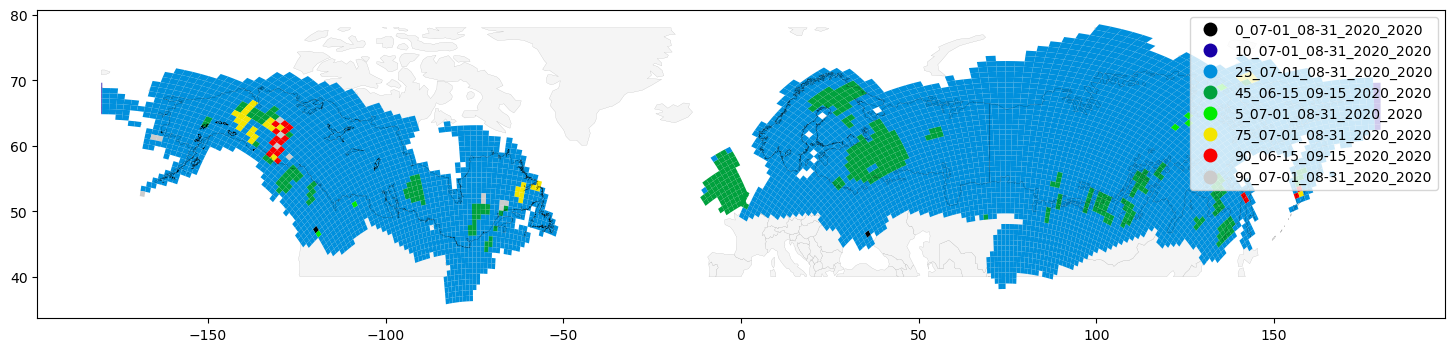

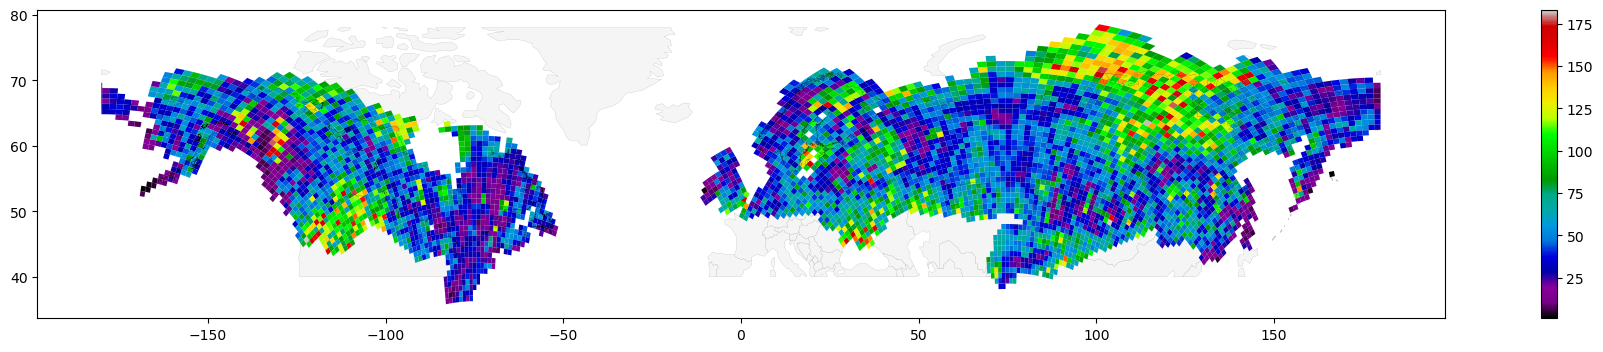

In [199]:
#for YEAR in list(range(2016,2023+1)):
for YEAR in [2020]:
    mscomp_params_table_fn = f'/projects/my-public-bucket/DPS_tile_lists/HLS/HLS_stack_2023_v1/HLS_H30_{YEAR}/HLS_input_params.csv'
    CURRENT_COMPLETE_HLS_input_params_df = pd.read_csv(mscomp_params_table_fn)
        
    CURRENT_COMPLETE_tindex = boreal_tile_index.merge(CURRENT_COMPLETE_HLS_input_params_df[['tile_num','run_type','num_scenes']], how='left', left_on='tile_num', right_on='tile_num')
    CURRENT_COMPLETE_tindex.groupby(['run_type']).size()
    CURRENT_COMPLETE_tindex.to_file(os.path.join(os.path.dirname(mscomp_params_table_fn),'HLS_input_params.gpkg'), driver='GPKG')
    MISSING_TILES = set(boreal_tile_index.tile_num.to_list()) - set(CURRENT_COMPLETE_HLS_input_params_df.tile_num.to_list())
    print(f"{len(MISSING_TILES)} missing out of {boreal_tile_index.shape[0]}")
    
    ExtractUtils.plot_gdf_on_world(CURRENT_COMPLETE_tindex)
    ExtractUtils.plot_gdf_on_world(CURRENT_COMPLETE_tindex, MAP_COL="num_scenes")

In [59]:
DPS_INPUT_TILE_NUM_LIST = list(MISSING_TILES)
DPS_INPUT_TILE_NUM_LIST

[]

In [122]:
#boreal_tile_index[boreal_tile_index.tile_num.isin(MISSING_TILES)].explore()

In [123]:
#CURRENT_COMPLETE_tindex_HLS_input_params.explore(column='num_scenes', cmap='nipy_spectral')

### The original spring 2022 HLS comp run types by tile
compositing requires trial and error to return tile composites that are free from cloud and seasonal artifacts  
these "run types" show the final set of compositing params used to return the composites for each tile

In [91]:
COMPLETED_TILES = CURRENT_COMPLETE_tindex_HLS_input_params.dropna().tile_num.to_list()

In [92]:
print(len(INPUT_TILE_NUM_LIST))
DPS_INPUT_TILE_NUM_LIST = set(INPUT_TILE_NUM_LIST) - set(COMPLETED_TILES)
len(DPS_INPUT_TILE_NUM_LIST)


4956


4393

### Map missing tiles by run_name

In [485]:
CURRENT_MISSING_tindex_HLS_input_params.fillna('None').info()

NameError: name 'CURRENT_MISSING_tindex_HLS_input_params' is not defined

In [ ]:
DPS_INPUT_TILE_NUM_LIST = CURRENT_MISSING_tindex_HLS_input_params.tile_num.to_list()
len(DPS_INPUT_TILE_NUM_LIST)

311

### Get tile dirs to delete

In [ ]:
if False:
    # delete tiles with num scenes < 40
    DELETE_TILE_NUM_LIST = CURRENT_COMPLETE_tindex_HLS_input_params[CURRENT_COMPLETE_tindex_HLS_input_params.num_scenes < 40].tile_num.to_list()
    len(DELETE_TILE_NUM_LIST)

    DPS_INPUT_TILE_NUM_LIST = DELETE_TILE_NUM_LIST
    len(DPS_INPUT_TILE_NUM_LIST)
    
    DELETE_DIR_LIST = [os.path.dirname(x) for x in CURRENT_tindex_matches_gdf[CURRENT_tindex_matches_gdf['tile_num'].isin(DELETE_TILE_NUM_LIST)].s3_path.to_list()]

else:
    # delete dup tiles
    dups_df = pd.read_csv(f'/projects/my-public-bucket/DPS_tile_lists/HLS/HLS_stack_2023_v1/{MS_COMP_NAME}/HLS_tindex_master_duplicates.csv')
    DELETE_DIR_LIST = [os.path.dirname(x) for x in dups_df.s3_path.to_list()]

print(len( DELETE_DIR_LIST))  
DELETE_DIR_LIST[0]

4471


's3://maap-ops-workspace/montesano/dps_output/do_HLS_stack_3-1-2/HLS_stack_2023_v1/HLS_H30_2019/mc90_07-01_08-31_2019_2019/2023/10/07/12/00/47/822951'

In [ ]:
dups_df['run_type'] = dups_df['local_path'].str.split('/', expand=True)[7]
dups_df.groupby(['run_type']).agg({'run_type':'count'})

run_type
run_type                            
mc50_07-01_08-31_2019_2019       535
mc75_07-01_08-31_2019_2019      1039
mc90_07-01_08-31_2019_2019      2897

### Delete the DPS dirs of these tiles


usage: aws s3 rm <S3Uri>
Error: Invalid argument type


In [ ]:
%%time
print(f'Deleting {len(DELETE_DIR_LIST)} dirs recursively ...')  
for d in DELETE_DIR_LIST:
    !aws s3 rm --quiet --recursive $d 

Deleting 4471 dirs recursively ...
CPU times: user 3min 41s, sys: 1min 46s, total: 5min 28s
Wall time: 6h 17min 32s


### Get difference between needs and haves

In [ ]:
DPS_INPUT_TILE_NUM_LIST = set(hls_tindex_master.tile_num.to_list()) - set(CURRENT_tindex_matches_gdf.tile_num.to_list())
len(DPS_INPUT_TILE_NUM_LIST)

307

### Get missing tiles over Land

AxesSubplot(0.125,0.276696;0.775x0.451609)


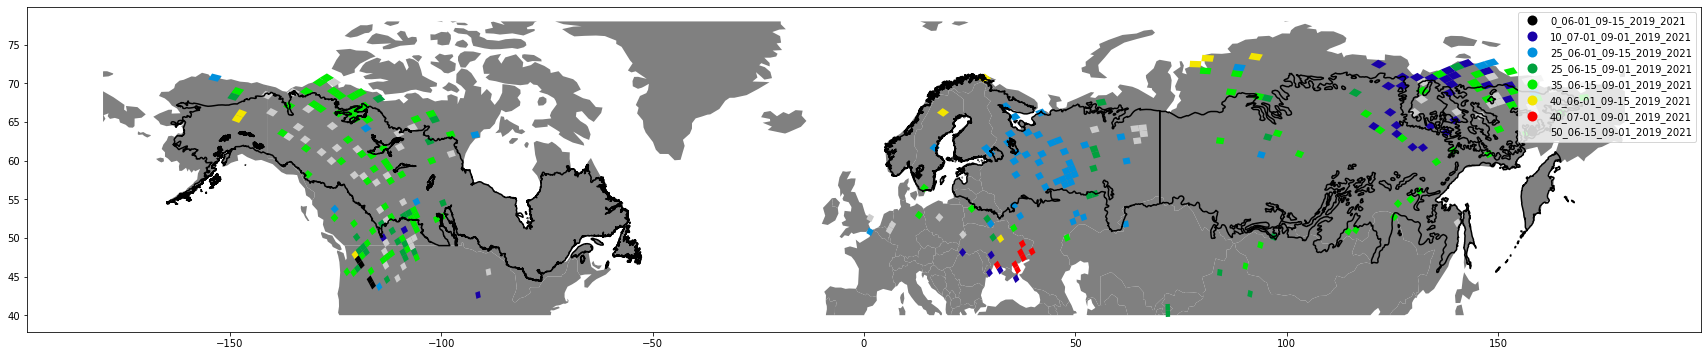

In [ ]:
# Use naturalearth to get land
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres") )
world['dissolve_field'] = 'for intersect'
geom_land = world.dissolve(by='dissolve_field').iloc[0].geometry
tmp_gdf = CURRENT_MISSING_tindex_HLS_input_params[~CURRENT_MISSING_tindex_HLS_input_params['tile_num'].isin(BAD_TILE_LIST)].to_crs(4326)
selector = tmp_gdf.intersects(geom_land)

CURRENT_MISSING_tindex_LAND = tmp_gdf[selector].to_crs(4326)

ExtractUtils.plot_gdf_on_world(CURRENT_MISSING_tindex_LAND.cx[-180:180, 40:90])

In [ ]:
DPS_INPUT_TILE_NUM_LIST = CURRENT_MISSING_tindex_LAND.tile_num.to_list()
len(DPS_INPUT_TILE_NUM_LIST)
#DPS_INPUT_TILE_NUM_LIST

4808

#### Selection from manual observation of tiles to redo

In [ ]:
redo_na = list(range(1207,1212+1)) + [993,34674,1050,34899,941,1271,1270,1152,1153,1154,1098,1099,1043,1044,890,899,888,842,843,2070,2071,1999,2000,2001,2002,2917,3001] + list(range(1926,1930+1)) 

In [ ]:
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
cntry = world.loc[ (world['name'] == 'United Kingdom') | (world['name'] == 'Ireland')] 

tiles_int = gpd.overlay(boreal_tile_index.to_crs(4326), cntry, how='intersection')

ax = cntry.plot()
tiles_int.boundary.plot(ax=ax, color='red')

redo_uk = tiles_int.tile_num.to_list()
print(len(redo_uk))

In [ ]:
REDO_TILE_NUM_LIST = redo_na + redo_eurasia + redo_uk 
REDO_TILE_NUM_LIST = redo_extra
print(len(REDO_TILE_NUM_LIST))

39


# View the Results with Folium

In [103]:
BAD_TILE_LIST = [] #[3540,3634,3728,3823,3916,4004,41995,41807,41619]

In [104]:
MS_COMP_NAME

'HLS_H30_2023'

In [106]:
HLS_mosaic_json_fn = f's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/HLS/{ALG_VERSION}/{MS_COMP_NAME}/HLS_tindex_master_mosaic.json'
HLS_mosaic_json_fn

's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/HLS/HLS_stack_2023_v1/HLS_H30_2023/HLS_tindex_master_mosaic.json'

In [ ]:
import importlib
importlib.reload(maplib_folium)

# Setup the mosaic tiling
tiler_base = "https://jqsd6bqdsf.execute-api.us-west-2.amazonaws.com/" #titiler.maap-project.org
tiler_mosaic =  "".join([tiler_base, "mosaicjson/tiles/{z}/{x}/{y}"])

boreal_tile_index = gpd.read_file('/projects/shared-buckets/montesano/databank/boreal_tiles_v004.gpkg')
Topo_mosaic_json_fn  = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/Topo_tindex_master_mosaic.json'

MS_BANDNAME = 'NBR2'
MS_BANDMIN=0.25
MS_BANDMAX=0.45 
MS_BANDNUM=13 
MS_BANDCOLORBAR='nipy_spectral'

HLS_mosaic_fall2022_json_fn = f's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_tindex_master_mosaic.json'
HLS_mosaic_fall2022_FIX_json_fn = f's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/fall2022_fix_irregulars/HLS_stack_2022_v2/12/HLS_tindex_master_mosaic.json'

# Phase 3 HLS coms
HLS_mosaic_c2015_json_fn = f's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/c2015/HLS_stack_2022_v2/11/HLS_tindex_master_mosaic.json' 
HLS_mosaic_2016_json_fn = f's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/HLS/HLS_stack_2023_v1/HLS_H30_2016/HLS_tindex_master_mosaic.json'
HLS_mosaic_2017_json_fn = f's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/HLS/HLS_stack_2023_v1/HLS_H30_2017/HLS_tindex_master_mosaic.json'
HLS_mosaic_2018_json_fn = f's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/HLS/HLS_stack_2023_v1/HLS_H30_2018/HLS_tindex_master_mosaic.json'

HLS_mosaic_2022_json_fn = f's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/2022/HLS_stack_2023_v1/HLS_tindex_master_mosaic.json'


# Phase 3 HLS comp for c2020
HLS_mosaic_c2020_json_fn = f's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/c2020/HLS_stack_2023_v1/HLS_tindex_master_mosaic.json'

# Final Phase 2 HLS comp for c2020
#HLS_mosaic_c2020_json_fn = f's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/c2020/HLS_stack_2022_v2/HLS_tindex_master_mosaic.json'

# Final HLS comp for c2015


# Test of HLS comp for late winter
HLS_mosaic_c2020latewinter_json_fn = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/c2020latewinter/HLS_stack_2022_v2/HLS_tindex_master_mosaic.json'

mscomp_fall2022_FIX_tiles_layer = TileLayer(
            tiles= f"{tiler_mosaic}?url={HLS_mosaic_fall2022_FIX_json_fn}&rescale={MS_BANDMIN},{MS_BANDMAX}&bidx={MS_BANDNUM}&colormap_name={MS_BANDCOLORBAR}",
            opacity=1,
            name="fixed tiles HLS comp",
            attr="MAAP",
            overlay=True
        )

mscomp_c2020_tiles_layer = TileLayer(
            tiles= f"{tiler_mosaic}?url={HLS_mosaic_c2020_json_fn}&rescale={MS_BANDMIN},{MS_BANDMAX}&bidx={MS_BANDNUM}&colormap_name={MS_BANDCOLORBAR}",
            opacity=1,
            name="final c2020 HLS",
            attr="MAAP",
            overlay=True
        )

mscomp_c2015_tiles_layer = TileLayer(
            tiles= f"{tiler_mosaic}?url={HLS_mosaic_c2015_json_fn}&rescale={MS_BANDMIN},{MS_BANDMAX}&bidx={MS_BANDNUM}&colormap_name={MS_BANDCOLORBAR}",
            opacity=1,
            name="c2015 HLS",
            attr="MAAP",
            overlay=True
        )

mscomp_c2020latewinter_tiles_layer = TileLayer(
            tiles= f"{tiler_mosaic}?url={HLS_mosaic_c2020latewinter_json_fn}&rescale={MS_BANDMIN},{MS_BANDMAX}&bidx={MS_BANDNUM}&colormap_name={MS_BANDCOLORBAR}",
            opacity=1,
            name="Late Winter c2020 HLS comp",
            attr="MAAP",
            overlay=True
        )

mscomp_2016_tiles_layer = TileLayer(
            tiles= f"{tiler_mosaic}?url={HLS_mosaic_2016_json_fn}&rescale={MS_BANDMIN},{MS_BANDMAX}&bidx={MS_BANDNUM}&colormap_name={MS_BANDCOLORBAR}",
            opacity=1,
            name="2016 HLS",
            attr="MAAP",
            overlay=True
        )
mscomp_2017_tiles_layer = TileLayer(
            tiles= f"{tiler_mosaic}?url={HLS_mosaic_2017_json_fn}&rescale={MS_BANDMIN},{MS_BANDMAX}&bidx={MS_BANDNUM}&colormap_name={MS_BANDCOLORBAR}",
            opacity=1,
            name="2017 HLS",
            attr="MAAP",
            overlay=True
        )
mscomp_2018_tiles_layer = TileLayer(
            tiles= f"{tiler_mosaic}?url={HLS_mosaic_2018_json_fn}&rescale={MS_BANDMIN},{MS_BANDMAX}&bidx={MS_BANDNUM}&colormap_name={MS_BANDCOLORBAR}",
            opacity=1,
            name="2018 HLS",
            attr="MAAP",
            overlay=True
        )
mscomp_2022_tiles_layer = TileLayer(
            tiles= f"{tiler_mosaic}?url={HLS_mosaic_2022_json_fn}&rescale={MS_BANDMIN},{MS_BANDMAX}&bidx={MS_BANDNUM}&colormap_name={MS_BANDCOLORBAR}",
            opacity=1,
            name="2022 HLS",
            attr="MAAP",
            overlay=True
        )

# Dict for specifying a different MS comp band to map
MS_BAND_DICT = {
    'name': MS_BANDNAME,
    'min' : MS_BANDMIN ,
    'max' : MS_BANDMAX , 
    'num' : MS_BANDNUM, 
    'cmap' : MS_BANDCOLORBAR,
    'legend_name': MS_BANDNAME + ' from HLS'
}

maplib_folium.MAP_DPS_RESULTS(tiler_mosaic, 
                              boreal_tile_index[~boreal_tile_index['tile_num'].isin(BAD_TILE_LIST)], #bad_tiles 
                              #CURRENT_COMPLETE_tindex_HLS_input_params[~CURRENT_COMPLETE_tindex_HLS_input_params['tile_num'].isin(BAD_TILE_LIST)], 
                              boreal_tile_index[~boreal_tile_index['tile_num'].isin([])], 
                              #boreal_tile_index,
                              #CURRENT_MISSING_tindex_HLS_input_params[~CURRENT_MISSING_tindex_HLS_input_params['tile_num'].isin(BAD_TILE_LIST)], 
                              boreal_tile_index[boreal_tile_index['tile_num'].isin([])], 
                              MATCH_TILES_NAME='Current complete tiles',
                              CHECK_TILES_NAME='Current missing tiles',
                              mosaic_json_dict = 
                                  {     ######### PRODUCT LAYERS #######
                                        #---NASA ABoVE Aboveground Boreal Woody Biomass Density
                                        'agb_mosaic_json_s3_fn': None, # AGB_mosaic_json_fn,                                                           # < -- v. spring 2022 - bad overviews, but faster
                                        #'agb_mosaic_json_s3_fn': 's3://maap-ops-workspace/shared/nathanthomas/06/AGB_tindex_master_mosaic.json',# < -- v. summer 2022 - locally corrected overviews
                                        'topo_mosaic_json_s3_fn':   Topo_mosaic_json_fn,
                                        #'mscomp_mosaic_json_s3_fn': HLS_mosaic_json_fn_spring2022, 
                                        'mscomp_mosaic_json_s3_fn': HLS_mosaic_2017_json_fn, 
                                        #'mscomp_mosaic_json_s3_fn': 's3://maap-ops-workspace/shared/nathanthomas/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_tindex_master_mosaic.json',
                                        'worldcover_json_s3_fn': None,
                                        'tp_standage2020_json_s3_fn': None,
                                        'tp_tcc2020_json_s3_fn': None,
                                        'tp_tcc2020slope_json_s3_fn': None,
                                        'tp_tcc2020pvalue_json_s3_fn': None 
                                     },

                            MS_BAND_DICT=MS_BAND_DICT,
                            map_width=1500, map_height=750,
                            ADD_TILELAYER = {
                                                "layer": mscomp_2018_tiles_layer, #mscomp_c2015_tiles_layer, #mscomp_c2020latewinter_tiles_layer
                                                "cmap": MS_BANDCOLORBAR,
                                                "max_val": MS_BANDMAX,
                                                "caption": MS_BANDNAME + ' from ' + mscomp_2018_tiles_layer.layer_name
                                            }
                             )

### Examine a tile locally (download from s3)

In [ ]:
TILE_NUM = 2899
s3_fn = CURRENT_tindex_matches_gdf[CURRENT_tindex_matches_gdf.tile_num == TILE_NUM].s3_path.to_list()[0]
local_fn = '/projects/test_data/'+os.path.basename(s3_fn)

s3 = s3fs.S3FileSystem(anon=True)
s3.download(s3_fn, local_fn)

# Preserve DPS output with a unique `MS_COMP_NAME` to separate it from other dps output
When completely done with this composite:  
1. Choose a `RUN_NAME`: should be basic but descriptive enough to separate it from other runs.   
 - eg, the c2020 HLS comp could be `HLS_L30_c2020` while the one for only 2020 might be `HLS_H30_2020`  
 - Naming convention: `<COMP_TYPE>_<PRODUCT_TYPE>_<DESCRIPTION>`

2. Append `RUN_NAME` to `ALG_NAME`: `HLS_stack_2023_v1/HLS_H30_2020`  
3. AWS move test files into a test dir
4. Re-build tindex, mosaicjson

In [ ]:
PRESERVE_DPS = True

In [ ]:
MS_COMP_NAME = 'HLS_H30_2020'
print(MS_COMP_NAME)
print(ALG_VERSION)

HLS_H30_2020
HLS_stack_2023_v1


In [ ]:
FROM_DIR = f"s3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/{ALG_VERSION}/2023/" # this doesnt include the year subdir - just everything under it...
#TO_DIR =   f"s3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/{ALG_VERSION}/{MS_COMP_NAME}/2023/" # ...so you have to specify the year here
#FROM_DIR = f"s3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/{ALG_VERSION}/{MS_COMP_NAME}/04/"
TO_DIR =   f"s3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/{ALG_VERSION}/2023_junk/"
TO_DIR

's3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/HLS_stack_2023_v1/2023_junk/'

##### conda install -c conda-forge awscli

In [ ]:
if PRESERVE_DPS:
    !time aws s3 mv $FROM_DIR $TO_DIR --recursive

In [ ]:
DPS_MONTH_LIST = '04' # prob dont need this arg if you just preserved with a move into an MS_COMP_NAME dir
DPS_DAY_MIN = 1 # prob dont need this arg if you just preserved with a move into an MS_COMP_NAME dir
OUTDIR = f'/projects/my-public-bucket/DPS_tile_lists/HLS/{MS_COMP_NAME}/{ALG_VERSION}'
DPS_SUBDIR_ALG_VERSION = ALG_VERSION + '/' + MS_COMP_NAME
!mkdir -p $OUTDIR
print(DPS_SUBDIR_ALG_VERSION)
!time python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py --maap_version $DPS_SUBDIR_ALG_VERSION -alg_name 'do_HLS_stack_3-1-2_ubuntu' -t 'HLS' -y 2023 --dps_month_list $DPS_MONTH_LIST -d_min $DPS_DAY_MIN --outdir $OUTDIR
#!python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -h

HLS_stack_2023_v1/HLS_H30_2020
/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Building a list of tiles:
MAAP version:		HLS_stack_2023_v1/HLS_H30_2020
Type:		HLS
Year:		2023
Month:		['04']
Days:		1-31

Output dir:  /projects/my-public-bucket/DPS_tile_lists/HLS/HLS_H30_2020/HLS_stack_2023_v1
                                             s3_path  ...                                file
0  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...   HLS_207_07-01_08-31_2020_2020.tif
1  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...  HLS_3160_07-01_08-31_2020_2020.tif
2  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...  HLS_4122_07-01_08-31_2020_2020.tif
3  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...  HLS_3529_07-01_08

In [ ]:
%%time
mscomp_params_table_fn = ExtractUtils.write_mscomp_params_table(f'{OUTDIR}/HLS_tindex_master.csv',  
                                       MSCOMP_TYPE = 'HLS', mscomp_input_glob_str="output*context.json", mscomp_num_scenes_glob_str="master*.json", 
                                       cols_list=['in_tile_num','max_cloud','start_month_day','end_month_day','start_year','end_year'])

In [48]:
import plotlib
import rasterio
from rasterio.plot import show_hist, show
import numpy as np
import matplotlib.pyplot as plt

In [53]:
import importlib
importlib.reload(plotlib)

<module 'plotlib' from '/projects/code/icesat2_boreal/lib/plotlib.py'>

In [45]:
fn = '/projects/my-private-bucket/tmp/HLS_2422_07-01_08-31_2014_2014.tif'
fn = '/projects/my-public-bucket/local_output/HLS_3459_07-01_08-31_2020_2020.tif'

In [ ]:
outdir = os.path.dirname(fn)
rescaled_multiband_fn = os.path.join(outdir, os.path.basename(fn).replace('.tif','_rescaled_3band_temp.tif'))
print(rescaled_multiband_fn)
plotlib.rescale_multiband_for_plot(fn, rescaled_multiband_fn, bandlist = [6,4,3], pct=[25,85], nodata=-9999.0) 

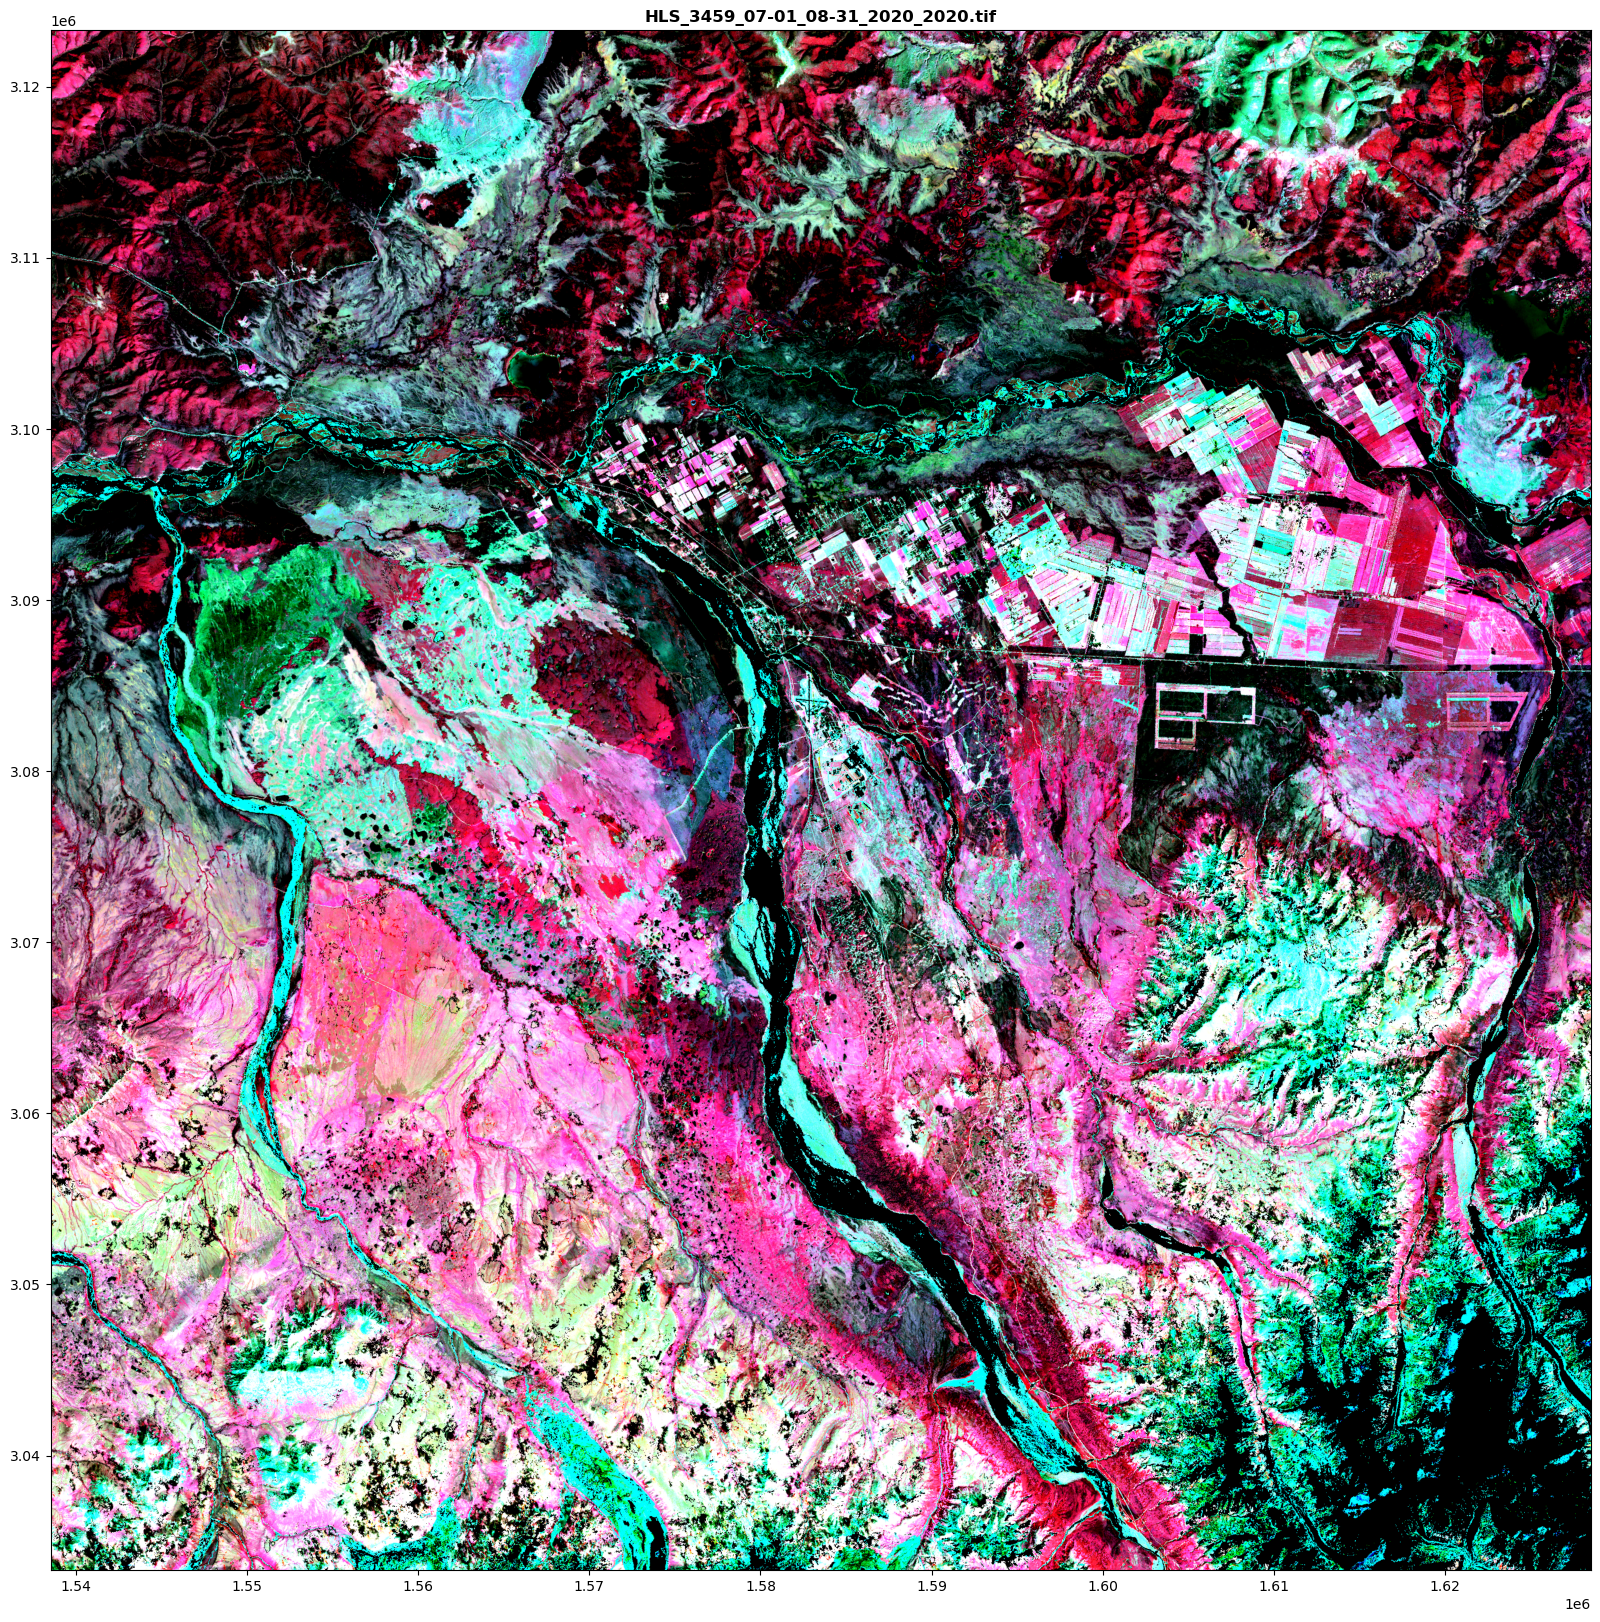

In [50]:
fig,ax=plt.subplots(figsize=(20,20))
with rasterio.open(rescaled_multiband_fn) as src:
    show(src.read(),transform=src.transform, ax=ax, title=os.path.basename(fn))